# Clinical Trial Matching Evaluation

This notebook evaluates an AI model's performance in matching patients to relevant clinical trials, analyzing the effectiveness of patient-trial eligibility predictions against gold standard judgments.

## Contents and Key Findings

1. **Data Processing Pipeline**:
   - Loads gold standard patient-trial pairs with relevance labels (0-2)
   - Processes model predictions with detailed reasoning for inclusion/exclusion decisions
   - Merges datasets to enable direct comparison between predictions and ground truth

2. **Evaluation Framework**:
   - Maps predictions to a 4-point scale: 
     - 0: Would not refer
     - 1: Would consider referral
     - 2: Highly likely to refer
     - 3: Not captured (cases not evaluated by model)
   - Calculates performance metrics excluding "Not captured" cases
   - Generates confusion matrices to visualize prediction patterns

3. **Performance Analysis**:
   - Detailed classification report showing precision, recall, and F1 score per class
   - Investigation of specific cases, including false negatives and true positives
   - Identification of patterns in model reasoning for both correct and incorrect predictions

4. **Threshold Optimization**:
   - Grid search approach to find optimal score cutpoints for classification
   - Separate optimization targets for overall performance (macro F1) and class-specific F1 scores
   - Visualizations of prediction distribution under different threshold settings

The analysis reveals both strengths and limitations in the current matching system, with the threshold optimization showing potential to improve performance by fine-tuning classification boundaries. The detailed examination of specific cases provides actionable insights for model improvement, particularly for reducing false negatives in high-priority matches.

This evaluation methodology combines quantitative metrics with qualitative analysis of prediction rationales, offering a comprehensive assessment of the clinical trial matching system's practical utility.

# --- Section 1: Imports and Configuration ---

In [1]:
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Configure pandas display settings for better readability in notebook
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 200)

# List directory contents using shell command
# ll ../data/sigir2016/old/matched

# --- Section 2: Data Loading and Path Configuration ---

In [2]:
# Define paths to data directories and files
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/old/matched" #"../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the three primary datasets:
# - TSV file: Contains gold standard patient-trial pairs with relevance scores
# - Queries: Patient data (each patient is a query)
# - Corpus: Clinical trial data (each trial is a document in the corpus)
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
# Rename 'score' column to 'label' in the gold standard dataframe
df_tsv = df_tsv.rename(columns={'score': 'label'})
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

# Display dataset sizes to verify loading
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

# Preview the loaded datasets
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())

 df_tsv 3870 df_queries 59 df_corpus 3626


,query-id,corpus-id,label
0,sigir-20141,NCT00000408,0
1,sigir-20141,NCT00000492,1
2,sigir-20141,NCT00000501,0
3,sigir-20141,NCT00001853,0
4,sigir-20141,NCT00004727,0


,_id,text
0,sigir-20141,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...
1,sigir-20142,"An 8-year-old male presents in March to the ER with fever up to 39 C, dyspnea and cough for 2 days. He has just returned from a 5 day vacation in Colorado. Parents report that prior to the onset o..."
2,sigir-20143,A 58-year-old nonsmoker white female with mild exertional dyspnea and occasional cough is found to have a left lung mass on chest x-ray. She is otherwise asymptomatic. A neurologic examination is ...
3,sigir-20144,"A 2-year-old boy is brought to the emergency department by his parents for 5 days of high fever and irritability. The physical exam reveals conjunctivitis, strawberry tongue, inflammation of the h..."
4,sigir-20145,A 56-year-old female on 20th day post-left mastectomy presents to the emergency department complaining of shortness of breath and malaise. The patient says that she has remained in bed for the las...


,_id,title,metadata
0,NCT00000369,Maintenance Therapies in Bipolar Disorders,"{'phase': 'Phase 3', 'drugs': '['Individual psychotherapy', 'Lithium carbonate']', 'drugs_list': ['Individual psychotherapy', 'Lithium carbonate'], 'diseases_list': ['Bipolar Disorder'], 'enrollme..."
1,NCT00000402,Calcium and Bone Mass in Young Females,"{'phase': 'Phase 2', 'drugs': '['Calcium']', 'drugs_list': ['Calcium'], 'diseases_list': ['Osteoporosis'], 'enrollment': '354', 'inclusion_criteria': '- Pubertal stage II - Calcium intake below a ..."
2,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education evaluation'], 'diseases_list': ['Low Back Pain'], 'enrollment': '580', 'inclusion_criteria': '- Must..."
3,NCT00000430,Low-Dose Hormone Replacement Therapy and Alendronate for Osteoporosis,"{'phase': 'Phase 3', 'drugs': '['Alendronate', 'Estrogen/progestin therapy']', 'drugs_list': ['Alendronate', 'Estrogen/progestin therapy'], 'diseases_list': ['Osteopenia', 'Osteoporosis'], 'enroll..."
4,NCT00000432,Lyme Disease Prevention Program,"{'phase': 'Phase 3', 'drugs': '['Education about disease prevention']', 'drugs_list': ['Education about disease prevention'], 'diseases_list': ['Lyme Disease', 'Tick-Borne Diseases'], 'enrollment'..."


# --- Section 3: Loading and Flattening Trial Matches Data ---

In [3]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the model's prediction results from JSON
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flatten the nested JSON structure into a list of records
# Each record represents a patient-trial evaluation with detailed matching results
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result - overall match scoring
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result - reasons patient might be excluded
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result - inclusion criteria evaluation
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Convert to DataFrame for easier manipulation
df_trial_matches = pd.DataFrame(records)

# Display number of evaluations processed
len(df_trial_matches)

7552

# --- Section 4: Merging and Preprocessing Data ---

In [4]:
# Merge gold standard data (df_tsv) with model predictions (df_trial_matches)
# Using left join to keep all gold standard pairs, even if model didn't evaluate them
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

# 1. Add patient information from queries dataset
merged_df = merged_df.merge(
    df_queries.rename(columns={'_id': 'query-id'}),
    on='query-id',
    how='left'
)

# 2. Add trial information from corpus dataset
merged_df = merged_df.merge(
    df_corpus.rename(columns={'_id': 'corpus-id'}),
    on='corpus-id',
    how='left'
)
# Remove redundant title column
merged_df = merged_df.drop(columns=['title'])

# Check possible match verdict values
(merged_df['match_verdict']).unique()

array([nan, 'HIGHLY LIKELY TO REFER', 'WOULD CONSIDER REFERRAL', None,
       'WOULD NOT REFER'], dtype=object)

# --- Section 5: Handling Missing Values and Label Encoding ---

In [5]:
# Handle missing verdicts:
# - If all verdicts are missing, the pair was not evaluated by the model
# - If exclusion/inclusion verdicts exist but overall verdict is missing, treat as "WOULD NOT REFER"
def maybe_not_captured(row):
    if pd.isna(row['match_verdict']) and pd.isna(row['exclusion_verdict']) and pd.isna(row['inclusion_verdict']):
        return "Not captured"  # genuinely not evaluated
    if pd.isna(row['match_verdict']):
        return "WOULD NOT REFER"  # evaluated, but no overall verdict (treat as 0)
    return row['match_verdict']

merged_df['match_verdict'] = merged_df.apply(maybe_not_captured, axis=1)

# Fix missing scores:
# If a verdict exists but score is missing, set score to 0
def fix_score(row):
    # If either verdict is present, set to 0 (evaluated, but no score)
    if pd.notna(row['exclusion_verdict']) or pd.notna(row['inclusion_verdict']):
        return "0"
    # If both are missing, leave as NaN
    return np.nan

# Apply score fix only to rows where 'score' is null
mask = merged_df['score'].isna()
merged_df.loc[mask, 'score'] = merged_df[mask].apply(fix_score, axis=1)

# Map text verdicts to numeric labels for evaluation:
# 2 = Highly likely to refer
# 1 = Would consider referral
# 0 = Would not refer
# 3 = Not captured (special case for pairs not evaluated by model)
verdict_map = {
    "HIGHLY LIKELY TO REFER": 2,
    "WOULD CONSIDER REFERRAL": 1,
    "WOULD NOT REFER": 0,
    "Not captured": 3
}
merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map).astype(int)

# Preview the merged and processed dataset
display(merged_df)

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
0,sigir-20141,NCT00000408,0,NaN,NaN,Not captured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education evaluation'], 'diseases_list': ['Low Back Pain'], 'enrollment': '580', 'inclusion_criteria': '- Must...",3
1,sigir-20141,NCT00000492,1,NaN,NaN,Not captured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...,"{'phase': 'Phase 3', 'drugs': '['propranolol']', 'drugs_list': ['propranolol'], 'diseases_list': ['Arrhythmia', 'Cardiovascular Diseases', 'Coronary Disease', 'Death, Sudden, Cardiac', 'Heart Dise...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3868,sigir-20159,NCT02612896,0,NaN,NaN,Not captured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortness of breath. Two weeks ago the patient was seen by his pediatrician for low-grade fever, abdominal ...","{'phase': 'N/A', 'drugs': '['Mass drug administration, praziquantel 10mg/kg', 'Health education']', 'drugs_list': ['Mass drug administration, praziquantel 10mg/kg', 'Health education'], 'diseases_...",3
3869,sigir-20159,NCT02633319,0,NaN,NaN,Not captured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortness of breath. Two weeks ago the patient was seen by his pediatrician for low-grade fever, abdominal ...","{'phase': 'N/A', 'drugs': '['Skilful Parenting', 'Agrics']', 'drugs_list': ['Skilful Parenting', 'Agrics'], 'diseases_list': ['Child Abuse', 'Parenting'], 'enrollment': '240', 'inclusion_criteria'...",3


# --- Section 6: Evaluation and Confusion Matrix ---

In [6]:
# Extract ground truth labels and predictions
y_true = merged_df['label'].astype(int)  # Gold standard labels
y_pred = merged_df['predicted_label'].astype(int)  # Model predictions

# Define label sets and readable names
labels_true = [0, 1, 2]  # Gold standard only has 3 classes
labels_pred = [0, 1, 2, 3]  # Predictions have a 4th class for "not captured"

label_names_true = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]
label_names_pred = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer",
    "3) Not captured"
]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_pred)
cm = cm[:3, :]  # Only first 3 rows (since y_true only in {0,1,2})

# Display confusion matrix as a DataFrame for readability
cm_df = pd.DataFrame(
    cm,
    index=label_names_true,
    columns=label_names_pred
)

# --- Section 7: Calculate Metrics Excluding "Not Captured" Cases ---

 length df_tsv:3870 length df_queries:59 length df_corpus:3626



,0) Would not refer,1) Would consider referral,2) Highly likely to refer,3) Not captured
0) Would not refer,782,398,51,1533
1) Would consider referral,139,302,92,152
2) Highly likely to refer,65,151,144,61



Macro F1 score (excluding "Not captured" predictions): 0.5290

Detailed classification report (excluding 'Not captured'):

                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.64      0.71      1231
1) Would consider referral       0.35      0.57      0.44       533
 2) Highly likely to refer       0.50      0.40      0.45       360

                  accuracy                           0.58      2124
                 macro avg       0.55      0.53      0.53      2124
              weighted avg       0.63      0.58      0.59      2124



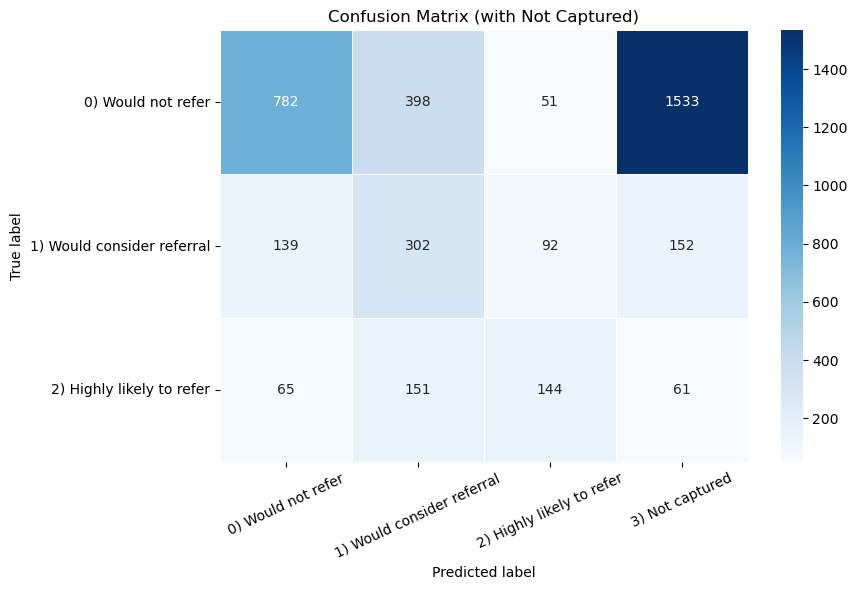

In [7]:
# Output dataset sizes for verification
print(f" length df_tsv:{len(df_tsv)} length df_queries:{len(df_queries)} length df_corpus:{len(df_corpus)}\n")
# Display confusion matrix
display(cm_df)
# Filter to only include evaluated pairs (excluding "Not captured")
mask_eval = y_pred.isin([0,1,2])
y_true_eval = y_true[mask_eval]
y_pred_eval = y_pred[mask_eval]

label_names = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

# Calculate F1 score and classification report
f1 = f1_score(y_true_eval, y_pred_eval, labels=[0,1,2], average='macro')
print(f'\nMacro F1 score (excluding "Not captured" predictions): {f1:.4f}\n')

print("Detailed classification report (excluding 'Not captured'):\n")
print(classification_report(
    y_true_eval, y_pred_eval, labels=[0,1,2], target_names=label_names
))

# Visualize confusion matrix with heatmap
plt.figure(figsize=(9,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (with Not Captured)')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# --- Section 8: Detailed Analysis of Specific Prediction Cases ---

In [8]:
# Adjust display settings to show more rows
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [9]:
# Case 1: Analyze false negatives - should be "Highly likely" but predicted as "Would not refer"
df_true2_pred = merged_df[(merged_df["label"] == 2) & (merged_df["predicted_label"] == 0)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
299,sigir-201413,NCT00163709,2,BNP Testing in Patients With SOB on Presentation to ED,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. The patient's shortness of breath is not specified...,FAIL,None,The patient's age is below the specified threshold of over 40 years old.,"The patient is 30 years old, which clearly does not meet the inclusion criterion of being over 4...",A 30-year-old generally healthy woman presents with shortness of breath that had started 2 hours...,"{'phase': 'Phase 1', 'drugs': '['BNP test']', 'drugs_list': ['BNP test'], 'diseases_list': ['Hea...",0
377,sigir-201414,NCT01075035,2,Multimodal Neurodiagnostic Imaging of Traumatic Brain Injury and Post-Traumatic Stress Disorder,0,WOULD NOT REFER,None,PASS,"Patient does not meet any exclusion criteria. Although some information is missing, such as the ...",FAIL,None,"1. At least 18 years of age and non-active duty (specifically, the age criterion is not an issue...","The patient's age is 85, which meets the age requirement of at least 18 years. However, the pati...",An 85-year-old man is brought to the ER because of gradual decrease in his level of consciousnes...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Traumatic Brain Injury', 'P...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,sigir-20155,NCT01886846,2,Plasma Adiponectin Levels and Relations With Cytokines in Children With Acute Rheumatic Fever,2,WOULD NOT REFER,"- The patient's medical condition, characterized by joint pain, fatigue, swelling, stiffness, fe...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified,A 31-year-old woman with no previous medical problems comes to the emergency room with a history...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Acute Rheumatic Fever'], 'e...",0
3630,sigir-20156,NCT01247077,2,Neuropsychologic and Immunological Evaluation in Treatment of Thyroid Diseases. Is Selenium Effi...,0,WOULD NOT REFER,None,EXCLUDE,"The patient meets the exclusion criterion of ""No severe ophthalmopathy, or other severe disease""...",None,None,None,None,"A 46-year-old woman presents with a 9 month history of weight loss (20 lb), sweating, insomnia ...","{'phase': 'Phase 2', 'drugs': '['selenium', 'placebo']', 'drugs_list': ['selenium', 'placebo'], ...",0


Rows: 65


In [10]:
# Case 2: Analyze true positives for "Highly likely to refer" class
df_true2_pred = merged_df[(merged_df["label"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
6,sigir-20141,NCT00005485,2,Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans,8,HIGHLY LIKELY TO REFER,The patient's profile aligns well with the clinical trial's focus on cardiovascular diseases in ...,PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient's demographics section clearly states that their ethnicity is African-American, whic...",A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Cardiovascular Diseases', '...",2
172,sigir-201410,NCT01599195,2,Use of Amplified Sound Signal to Identify Presence of Carotid and Femoral Stenosis,8,HIGHLY LIKELY TO REFER,"The patient's medical condition, which includes a pulsatile mass in the right groin, loss of dis...",PASS,"Patient does not meet any exclusion criteria. The patient's age is 67 years, which falls within ...",INCLUDE,None,None,"The patient's age is 67 years, which falls within the specified range of 19-90 years. The patien...",A physician is called to see a 67-year-old woman who underwent cardiac catheterization via the r...,"{'phase': 'N/A', 'drugs': '['AudioDoc']', 'drugs_list': ['AudioDoc'], 'diseases_list': ['Carotid...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3688,sigir-20157,NCT00290914,2,Safety and Efficacy Study of Vilazodone and Discovering Genetic Markers Associated With Response...,8,HIGHLY LIKELY TO REFER,"The patient's symptoms, such as fatigue, increased sleep and appetite, difficulty concentrating,...",PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient is a 20-year-old female, which falls within the specified age range of 18-65 years a...",A 20 yo female college student with no significant past medical history presents with a chief co...,"{'phase': 'Phase 2', 'drugs': '['Vilazodone']', 'drugs_list': ['Vilazodone'], 'diseases_list': [...",2
3749,sigir-20157,NCT01682785,2,Incidence of Metabolic Syndrome and Thyroid Dysfunction in Patients With Major Depressive Disorder,8,HIGHLY LIKELY TO REFER,"The patient's symptoms, such as increased sleep and appetite, difficulty concentrating, loss of ...",PASS,Patient does not meet any exclusion criteria. The exclusion criterion states that a subject who ...,INCLUDE,None,None,"Although the patient's diagnosis is not explicitly stated as major depressive disorder, the prim...",A 20 yo female college student with no significant past medical history presents with a chief co...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Major Depressive Disorder',...",2


Rows: 144


In [11]:
# Case 3: Analyze true positives for "Would consider referral" class
df_true1_pred = merged_df[(merged_df["label"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
22,sigir-20141,NCT00225355,1,Rosiglitazone Versus Placebo in Chronic Stable Angina,5,WOULD CONSIDER REFERRAL,The patient's chief complaint of episodic pressing/burning anterior chest pain could suggest ang...,PASS,Patient does not meet any exclusion criteria. The patient's medical history does not mention dia...,UNDETERMINED,- Results of a previous positive exercise tolerance test\n- Disease suitability for coronary int...,None,The patient's summary lacks crucial details necessary to determine eligibility for the clinical ...,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'Phase 4', 'drugs': '['Rosiglitazone']', 'drugs_list': ['Rosiglitazone'], 'diseases_li...",1
48,sigir-20141,NCT00797953,1,Phase II Multi-Center Study of T89 to Treat Chronic Stable Angina,5,WOULD CONSIDER REFERRAL,"The patient presents with episodic chest pain, which could be indicative of angina, aligning wit...",PASS,Patient does not meet any exclusion criteria. Although the patient presents with episodic chest ...,UNDETERMINED,- Evidence of coronary artery disease (myocardial infarction or significant coronary artery dise...,None,"The patient presents with episodic chest pain, which could be indicative of angina, but there is...",A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'Phase 2', 'drugs': '['T89']', 'drugs_list': ['T89'], 'diseases_list': ['Angina Pector...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3807,sigir-20158,NCT02053012,1,Investigating Reaction Time Among Children Who Snore,5,WOULD CONSIDER REFERRAL,"The patient's chief complaint of nighttime snoring, pauses in breathing, restlessness, and night...",PASS,Patient does not meet any exclusion criteria. The exclusion criterion mentions children who are ...,UNDETERMINED,"- Information about the patient's cognitive abilities, educational level, or any developmental i...",None,"The patient is 10 years old, and while many children at this age can understand and perform simp...","A 10 yo boy with nighttime snoring, pauses in breathing, and restlessness with nighttime awakeni...","{'phase': 'N/A', 'drugs': '['PVT-192']', 'drugs_list': ['PVT-192'], 'diseases_list': ['Snoring']...",1
3816,sigir-20158,NCT02562040,1,Pediatric Adenotonsillectomy for Snoring,5,WOULD CONSIDER REFERRAL,"The patient's symptoms, such as nighttime snoring, pauses in breathing, restlessness, and nightt...",PASS,Patient does not meet any exclusion criteria. The provided patient information does not contain ...,UNDETERMINED,- Obstructive apnea index (OAI) and apnea-hypopnea index (AHI) values from nocturnal polysomnogr...,None,"The patient presents with symptoms suggestive of sleep-disordered breathing, such as nighttime s...","A 10 yo boy with nighttime snoring, pauses in breathing, and restlessness with nighttime awakeni...","{'phase': 'Phase 3', 'drugs': '['Early Adenotonsillectomy (eAT)', 'Watchful Waiting with Support...",1


Rows: 302


In [12]:
# Case 4: Analyze true positives for "Would not refer" class
df_true0_pred = merged_df[(merged_df["label"] == 0) & (merged_df["predicted_label"] == 0)]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
17,sigir-20141,NCT00166231,0,Understanding Pediatric Chest Pain and Other Symptoms,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. The only exclusion criterion mentioned is for non-...,FAIL,None,"- Age: The patient is 58 years old, which is outside the 8-18 years of age range specified in th...",The primary reason for the verdict is the clear mismatch between the patient's age and the age r...,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Chest Pain'], 'enrollment':...",0
34,sigir-20141,NCT00462241,0,"Treatment Study Comparing Manual Treatment or Advice in Acute, Musculoskeletal Chest Pain",0,WOULD NOT REFER,None,EXCLUDE,"The patient's chief complaint is episodic pressing/burning anterior chest pain, which is not rel...",None,None,None,None,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'N/A', 'drugs': '['chiropractic treatment', 'Self-management']', 'drugs_list': ['chiro...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,sigir-20159,NCT02258763,0,Trial on the Ideal Duration of Oral Antibiotics in Children With Pneumonia,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. Although the patient has a recent history of viral...,FAIL,None,"- Age: The patient is 10 years old, which exceeds the specified age range of 3 months to 59 mont...","The patient's age is the primary reason for the FAIL verdict, as it clearly exceeds the specifie...","A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortnes...","{'phase': 'Phase 4', 'drugs': '['Amoxicillin-Potassium Clavulanate Combination', 'Placebo']', 'd...",0
3865,sigir-20159,NCT02459171,0,Household Transmission of Zoonotic Influenza Viruses in a Cohort of Egyptian Poultry Growers,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. There is no indication of a known immunosuppressiv...,FAIL,None,"- The criterion that requires individuals to have poultry in the household is not met, as the pa...",The trial specifically includes poultry-exposed individuals with poultry in the household. The p...,"A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortnes...","{'phase': 'N/A', 'drugs': '['Questionnaire', 'Blood sample', 'Nasal wash', 'Throat swab']', 'dru...",0


Rows: 782


# --- Section 9: Threshold Optimization ---


Best cutpoints for macro F1: cut1=5, cut2=7, F1=0.5379
Classification Report (excluding 'Not captured'):
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.67      0.73      1231
1) Would consider referral       0.38      0.51      0.43       533
 2) Highly likely to refer       0.45      0.46      0.45       360

                  accuracy                           0.59      2124
                 macro avg       0.54      0.55      0.54      2124
              weighted avg       0.63      0.59      0.61      2124

Confusion Matrix (with 'Not captured'):


,0) Would not refer,1) Would consider referral,2) Highly likely to refer,3) Not captured
0) Would not refer,824,325,82,1533
1) Would consider referral,146,272,115,152
2) Highly likely to refer,70,126,164,61


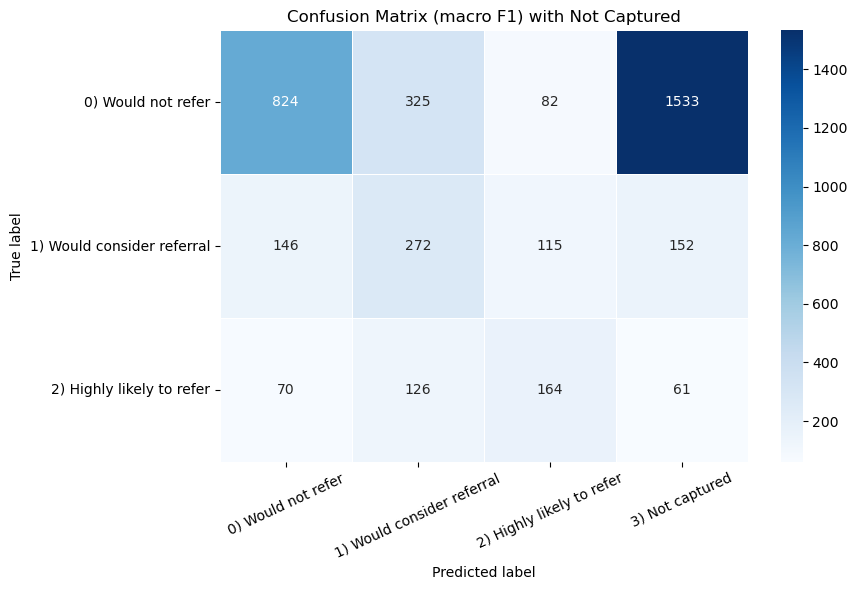

In [13]:
# Extract rows with ground truth labels, tracking which have model predictions
yx_complete = merged_df.loc[~merged_df['label'].isna(), ['score', 'label', 'predicted_label']]
has_prediction = ~yx_complete['score'].isna()

# Extract numeric scores for threshold optimization
yx_numeric = yx_complete.loc[has_prediction, ['score', 'label']]
score_numeric = yx_numeric['score'].values.astype(int)  # model output scores
label = yx_complete['label'].values.astype(int)  # true labels for all rows

# Grid search for optimal threshold cutpoints
# Iterate through all possible cutpoint combinations
results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        # Create predictions using the current cutpoints
        numeric_preds = np.digitize(score_numeric, bins=[cut1, cut2])  # Maps to (0, 1, 2)
        
        # Create complete predictions array, preserving "Not captured" (3)
        preds = np.full(len(label), 3)  # Default to "Not captured"
        preds[has_prediction.values] = numeric_preds  # Fill in predictions where available
        
        # Calculate metrics using only predictions that aren't "Not captured"
        mask_eval = preds != 3
        macro_f1 = f1_score(label[mask_eval], preds[mask_eval], labels=[0, 1, 2], average="macro")
        
        # Calculate per-class F1 scores
        class_f1 = f1_score(label[mask_eval], preds[mask_eval], labels=[0, 1, 2], average=None)
        f1_0, f1_1, f1_2 = class_f1
        
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_0": f1_0,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find optimal cutpoints for different objectives
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]  # Best overall F1
best_0 = results_df.loc[results_df['f1_0'].idxmax()]  # Best for "Would not refer" class
best_1 = results_df.loc[results_df['f1_1'].idxmax()]  # Best for "Would consider" class
best_2 = results_df.loc[results_df['f1_2'].idxmax()]  # Best for "Highly likely" class

# Define human-readable labels
cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

all_labels = cut_labels + ["3) Not captured"]

# Function to display evaluation results for a specific cutpoint set
# Fixed function to avoid parameter naming confusion
def display_results_with_plot(cut1, cut2, label_name, f1val):
    # Create predictions using the specified cutpoints
    numeric_preds = np.digitize(score_numeric, bins=[cut1, cut2])  # (0, 1, 2)
    
    # Create complete predictions array, preserving "Not captured" (3)
    preds = np.full(len(label), 3)  # Default to "Not captured"
    preds[has_prediction.values] = numeric_preds  # Fill in predictions where available
    
    print(f"\nBest cutpoints for {label_name}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    
    # Generate classification report (excluding "Not captured")
    mask_eval = preds != 3
    print("Classification Report (excluding 'Not captured'):")
    print(classification_report(
        label[mask_eval], preds[mask_eval], labels=[0, 1, 2],
        target_names=cut_labels
    ))
    
    # Generate full confusion matrix including "Not captured"
    cm = confusion_matrix(label, preds, labels=[0, 1, 2, 3])
    cm = cm[:3, :]  # Only first 3 rows (since y_true only in {0,1,2})
    
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=all_labels)
    print("Confusion Matrix (with 'Not captured'):")
    display(cm_df)

    # Visualize confusion matrix with heatmap
    plt.figure(figsize=(9,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label_name}) with Not Captured')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Display results for the optimal macro F1 cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)

# Optional: Display results for class-specific optimal cutpoints
# display_results_with_plot(int(best_0.cut1), int(best_0.cut2), "score 0 (Would not refer)", best_0.f1_0)
# display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
# display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)